# Motivation

The purpose of this code is to create a generative art algorithm with the following logic:

1. gather a list of $m$ colors
2. create 3D matrix of size $n$ to hold color values
3. randomly seed $m$ colors into the matrix
4. pick a new point $(x,y)$ on the matrix
5. look at $k$ neighboring points and compute the count of each of the color values
6. set the newly picked point as the maximum of the color values in its neighbors
7. if there are no neighbors, or no maximum, pick randomly from $m$ and set as color

repeat steps 4 to 7 untill all positions on the matrix are filled



Once this is done, symmetry can be incorp0orated

# Imports

In [1]:
import cv2 
import imutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns
from skimage import io
from PIL import Image
from itertools import combinations, permutations

# Explore Functionality

## without neighbor influence (random filling)

In [12]:
#create a 3d image
empty_img=np.zeros((10,10,3))

In [13]:
np.shape(empty_img)

(10, 10, 3)

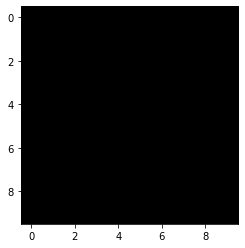

In [14]:
plt.imshow(empty_img)

https://bic-berkeley.github.io/psych-214-fall-2016/numpy_meshgrid.html

In [39]:
i_coords, j_coords = np.meshgrid(range(10), range(10), indexing='ij')

In [17]:
#coordinates list
perms=[i for i in permutations(np.arange(0,10),2)]
perms=perms+(list(zip(np.arange(10), np.arange(10))))


In [57]:
len(perms)

100

In [18]:
# pick 3 non-overlapping random points as seeds
try:
    [s1, s2, s3]= np.random.choice(10,3, replace=False)
    s1=perms[s1]
    s2=perms[s2]
    s3=perms[s3]
except IndexError:
    print(s1)
    print(s2)
    print(s3)

In [59]:
#color seeds
empty_img[s1[0],s1[1],:]=[1,0,0]#set to red
empty_img[s2[0],s2[1],:]=[0,1,0]#set to blue
empty_img[s3[0],s3[1],:]=[0,0,1]#set to green


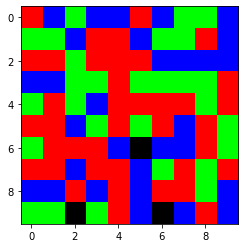

In [19]:
lenperm=len(perms)
while lenperm>0:
    try:
        [s1, s2, s3]= np.random.choice(100,3, replace=False)
        s1=perms[s1]
        s2=perms[s2]
        s3=perms[s3]
        
    except IndexError:
        print(s1)
        print(s2)
        print(s3)
    empty_img[s1[0],s1[1],:]=[1,0,0]#set to red
    empty_img[s2[0],s2[1],:]=[0,1,0]#set to blue
    empty_img[s3[0],s3[1],:]=[0,0,1]#set to green
    lenperm-=1
plt.imshow(empty_img)

Just a random shuffling of colors could be done faster by making an flat array of colors that are then shuffled and reshaped

## random with 1 by 1 tiling

In [78]:
size=10
empty_img=np.zeros((size,size,3))
perms=[i for i in permutations(np.arange(0,size),2)]
perms=perms+list(zip(np.arange(size), np.arange(size)))

In [509]:
class RandomFill:
    def __init__(self, size):
        self.size=size
        #create empty img
        self.empty_img=np.zeros((self.size,self.size,3))
        #create self.perms
        self.perms=[i for i in permutations(np.arange(0,self.size),2)]
        self.perms=self.perms+list(zip(np.arange(self.size), np.arange(self.size)))
        np.random.shuffle(self.perms)
        rng = np.random.default_rng()
        self.colorlist=[[0,0,1], [0,1,0],[1,0,0]]
        #seed
    def seedColors(self):
        #should automatically populate with # of colors in self.colorlist
        
        self.empty_img[self.perms[0]]=self.colorlist[2]#set to red
        self.empty_img[self.perms[1]]=self.colorlist[1]#set to blue
        self.empty_img[self.perms[2]]=self.colorlist[0]#set to green
    
    def pickRandomColor(self):
        return(rng.choice(self.colorlist))
        
    def paintPixel(self, i, color):
        self.empty_img[i]=color
        return(None)
    
    def paintRandomly(self):
        for i in self.perms[3:]:
            self.paintPixel(i, self.pickRandomColor())


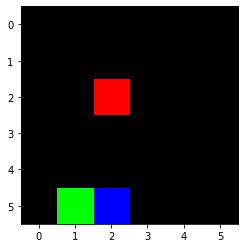

In [511]:
r=RandomFill(6)
r.seedColors()
# r.paintRandomly()
plt.imshow(r.empty_img)

# Fill With k neighbors

## get neighbors

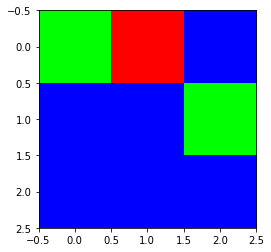

In [351]:
coordinate=(2,3)
k=1

cindx1=coordinate[0]-k
cindx2=coordinate[0]+(k+1)

cindy1=coordinate[1]-k
cindy2=coordinate[1]+(k+1)

kernel=r.empty_img[cindx1:cindx2,cindy1:cindy2,:]
plt.imshow(kernel)

In [353]:
im=Image.fromarray(np.uint8(kernel))
w, h = im.size  
colors = im.getcolors(w*h)

In [361]:
colors

[(6, (0, 0, 1)), (1, (1, 0, 0)), (2, (0, 1, 0))]

In [364]:
colSorted=sorted(colors, key=lambda tup: tup[0]) 

In [369]:
colSorted[-1][1]

(0, 0, 1)

what if run into edge

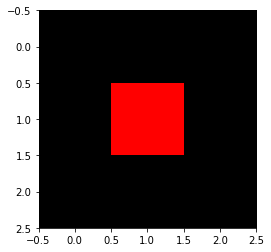

In [513]:
[rows, cols, depth]=np.shape(r.empty_img)
coordinate=(2,2)
k=1
cindx1=coordinate[0]-k
if cindx1<0:
    cindx1=0
cindx2=coordinate[0]+(k+1)
if cindx2>rows:
    cindx2=rows
cindy1=coordinate[1]-k
if cindy1<0:
    cindy1=0
cindy2=coordinate[1]+(k+1)
if cindy2>cols:
    cindy2=cols
    
kernel=r.empty_img[cindx1:cindx2,cindy1:cindy2,:]
plt.imshow(kernel)

In [636]:
def returnKernel(img,cord,k):
    [rows, cols, depth]=np.shape(img)
    cindx1=cord[0]-k
    if cindx1<0:
        cindx1=0
    cindx2=cord[0]+(k+1)
    if cindx2>rows:
        cindx2=rows
    cindy1=cord[1]-k
    if cindy1<0:
        cindy1=0
    cindy2=cord[1]+(k+1)
    if cindy2>cols:
        cindy2=cols

    kernel=img[cindx1:cindx2,cindy1:cindy2,:]
    
    return(kernel)

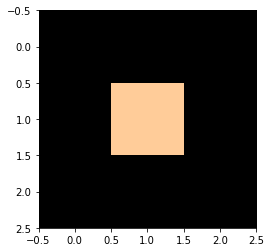

In [637]:
plt.imshow(returnKernel(r.empty_img,(2,2),1))

In [638]:
def getColorDist(img):
    im=Image.fromarray(np.uint8(img))
    w, h = im.size  
    colorDist = im.getcolors(w*h)
    #drop black
    colorDist= [i for i in colorDist if i[1]!=(0,0,0)]
    return(colorDist)

In [641]:
getColorDist(returnKernel(r.empty_img,(2,2),1))


[(1, (1, 0, 0))]

In [687]:
mykernel=returnKernel(r.empty_img,(2,2),1)

In [665]:
im=Image.fromarray(np.asarray(mykernel), mode='')

ValueError: Too many dimensions: 3 > 2.

In [661]:
im.getcolors(w*h)

[(9, (0, 0, 0))]

In [402]:
def sortColorDist(colorDist):
    colorSorted=sorted(colorDist, key=lambda tup: tup[0]) 
    return(colorSorted[-1][1])

In [403]:
sortColorDist(getColorDist(returnKernel(r.empty_img,(5,5),1)))

(1, 0, 0)

## new class for neighbor fill

In [6]:
class NeighborFill:
    def __init__(self, size, colorlist):
        self.size=size
        #create empty img
        self.empty_img=np.zeros((self.size,self.size,3))
        #create self.perms
        self.perms=[i for i in permutations(np.arange(0,self.size),2)]
        self.perms=self.perms+list(zip(np.arange(self.size), np.arange(self.size)))
        np.random.shuffle(self.perms)
        self.rng = np.random.default_rng()
        self.colorlist=colorlist
        
        #seed
        
    def seedColors(self):
        #should automatically populate with # of colors in self.colorlist
        for i in np.arange(len(self.colorlist)):
            self.empty_img[self.perms[i]]=self.colorlist[i]

    
    def pickRandomColor(self):
        return(self.rng.choice(self.colorlist))
        
    def paintPixel(self, i, color):
        self.empty_img[i]=color
        return(None)
    
    def paintRandomly(self):
        for i in self.perms[3:]:
            self.paintPixel(i, self.pickRandomColor())
            
    def returnKernel(self,img,cord,k):
        [rows, cols, depth]=np.shape(img)
        
        cindx1=cord[0]-k
        if cindx1<0:
            cindx1=0
        cindx2=cord[0]+(k+1)
        if cindx2>rows:
            cindx2=rows
        cindy1=cord[1]-k
        if cindy1<0:
            cindy1=0
        cindy2=cord[1]+(k+1)
        if cindy2>cols:
            cindy2=cols

        kernel=img[cindx1:cindx2,cindy1:cindy2,:]
    
        return(kernel)
    
    def getColorDist(self,kernel):
        im=kernel.astype(np.uint8)
        im=Image.fromarray(im, 'RGB')
        w, h = im.size  
        colorDist = im.getcolors(w*h)
#         print('colorDist all')
#         print(colorDist)
        #drop black
        colorDist= [i for i in colorDist if i[1]!=(0,0,0)]
#         print('colorDist w/o black')
#         print(colorDist)
        return(colorDist)
    
    def sortColorDist(self, colorDist):
        if not colorDist:
            topColor=self.pickRandomColor()
        else:
            colorSorted=sorted(colorDist, key=lambda tup: tup[0]) 
            topColor=colorSorted[-1][1]
        return(topColor)
    
    
    def paintbyNeighbor(self,k):
        for i in self.perms[3:]:
            maxColor=self.sortColorDist(self.getColorDist(self.returnKernel(self.empty_img,i,k)))
            self.paintPixel(i, maxColor)
            

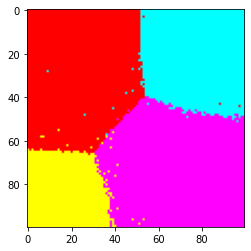

In [29]:
r=NeighborFill(100,[[1,0,0],[1,1,0],[0,1,1],[0,0,1], [1,0,1], [1,1,0]])
r.seedColors()
r.paintbyNeighbor(20)
plt.imshow(r.empty_img)

# Symmetric

In [37]:
def getHsym(img,x,y):
    [xsize,ysize, depth]=np.shape(img)
    mid=xsize/2
    if x>mid:
        newX=(xsize-x)
    if x<mid:
        newX=mid+x
    return(int(newX),y)

In [270]:
class SymmetryFill:
    def __init__(self, size, colorlist):
        self.size=size
        #create empty img
        self.empty_img=np.zeros((self.size,self.size,3))
        #create self.perms
        self.perms=[i for i in permutations(np.arange(0,self.size),2)]
        self.perms=self.perms+list(zip(np.arange(self.size), np.arange(self.size)))
        np.random.shuffle(self.perms)
        self.colorlist=colorlist
        self.randdist=[]

        #seed
        #could make an interesting algorithm where seedeing happens in a pre-defined pattern, like a cross or triangle


    def pickRandomColor(self):
        #in the case there is no max color, pick randomly
        randColor=self.colorlist[np.random.choice(np.arange(0,len(self.colorlist)))]
        self.randdist.append(randColor)
        return(randColor)
        
    def paintPixel(self, cord, color):
        #paints the pixel a certain color at coordinate given
        self.empty_img[cord]=color
        return(None)
    
            
    def returnKernel(self,img,cord,k):
        #kernel of width k, centered at cord
        
        [rows, cols, depth]=np.shape(img)#get image dimensions

        #get the x axis dimensions
        cindx1=cord[0]-k#left boundary
        if cindx1<0:#if hits border
            cindx1=0#set as border
        cindx2=cord[0]+(k+1)#right boundary
        if cindx2>rows:#if hits border
            cindx2=rows#set as border
        #get the y axis dimensions
        cindy1=cord[1]-k#bottom boundary
        if cindy1<0:#if hits bottom
            cindy1=0#set as bottom
        cindy2=cord[1]+(k+1)#top boundary
        if cindy2>cols:#if hits top
            cindy2=cols#set as top
            
        #put dimensions into index
        kernel=img[cindx1:cindx2,cindy1:cindy2,:]
    
        return(kernel)
    
    def getColorDist(self,kernel):
        self.colorDist=[]
        for i in self.colorlist:
            self.colorDist.append(np.count_nonzero(np.all(kernel==i,axis=2)))#array of counts only
            #order corresponds to colorlist order
        return(self.colorDist)
    
    def getTopColor(self,colorDist,how):
        #what if black, in this case colorDist=[0]
        if all(v==0 for v in colorDist):
            topColor=self.pickRandomColor()
#             print('picked random')
        else:
            #get top index
            if how=='top':
                topInd=np.argmax(colorDist)
#                 print(topInd)
                topColor=self.colorlist[topInd]
            if how=='prob':
                prob=self.colorDist/np.sum(self.colorDist)
                topInd=np.random.choice(np.arange(len(self.colorlist)),p=prob)
                topColor=self.colorlist[topInd]
        return(topColor)
    
    def getHsym(self,img,x,y):
        [xsize,ysize, depth]=np.shape(img)
        mid=xsize/2
        if x<mid:
            newX=mid+(mid-x)
        if x>mid:
            newX=mid-(x-mid)
        elif x==mid:
            newX=x
        return(y,int(newX-1))
    
    def paintbyNeighbor(self,k,p,how):
        for i in self.perms:
            self.cord=i
            self.kernel=self.returnKernel(self.empty_img,self.cord,k)
            self.colorDist=self.getColorDist(self.kernel)
#             print(self.colorDist)
            self.maxColor=self.getTopColor(self.colorDist,how)
            self.paintPixel(self.cord, self.maxColor)#paint that max color
            

            #now find symmetric coordinate
            if np.random.random()<p: #if get less than symmetry threshold
                self.symCord=self.getHsym(self.empty_img, self.cord[1],self.cord[0])#find symmetric cord
                #paint symmetric coordinate
                self.paintPixel(self.symCord, self.maxColor)#recolor that pixel but don't need to remove

    
            

In [108]:
mycols=[[0.34832334, 0.46571115, 0.88834616, 1.        ],
       [0.61931795, 0.74412073, 0.99893092, 1.        ],
       [0.75361062, 0.83023285, 0.96087116, 1.        ]]

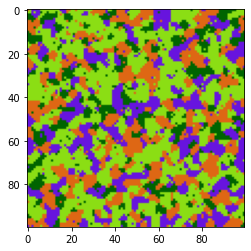

In [271]:
# r=SymmetryFill(300,[[1,0,0],[0,1,0],[0,0,1],[0,1,1],[1,0,1], [1,1,0]])
# r=SymmetryFill(100,[[1,0,0],[1,1,0]])
# r=SymmetryFill(300,[[1,0,0],[0,1,0],[0,0,1]])
# r=SymmetryFill(10,[[0.5,0.5,0.1],[0.2,0.1,0.1], [0.6,0.1,0]])
# r=SymmetryFill(100,[[0,0,1],[1,0,0], [0,1,0]])
# r=SymmetryFill(100, [[188,143,143], [255,239,213],[240,128,128]])
colorlist=[[139,222,20],[222,103,20],[103,20,222],[0,100,0]]

r=SymmetryFill(100, colorlist)

r.paintbyNeighbor(1,0.1,'top')
plt.imshow(r.empty_img.astype('uint8'))
# plt.imshow(r.empty_img)

In [265]:
r.colorDist

[8, 0, 0, 0]

In [210]:
import os
import imageio

In [255]:
os.chdir(r"C:\Users\al33m\Box\JupyterNotebooks\MyJupyterNotebooks\Social\images\4colors")

In [272]:
size=300
# colorlist=[[255,0,0],[0,255,0],[0,0,255]]
colorlist=[[139,222,20],[222,103,20],[103,20,222],[20,139,222]]

for spat in [1,5,10,15,30]:
    for sym in [0,0.1,0.5,1]:
        r=SymmetryFill(size, colorlist)
        r.paintbyNeighbor(spat,sym,'top')
        imageio.imwrite('spat_'+str(spat)+'_sym_'+str(sym)+'_top.png', r.empty_img.astype('uint8'))

In [155]:
import imageio

In [159]:
imageio.imwrite('hey.png', r.empty_img.astype('uint8'))